In [1]:
%load_ext autoreload
%autoreload 1
%reload_ext autoreload


%aimport src.utils.tardisml_utils

In [2]:
import xarray as xr
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import yaml
import pickle as pkl

import src.utils.load_config as load_config
import src.data_preparation.load_data as load_data
import src.feature_extraction.pca as feature_pca
import src.visualization.visualize_pca as visualize_pca
import src.visualization.visualize_error as visualize_error
from src.visualization.visualize_local_area import plot_land_mask

import src.utils.tardisml_utils as tardisml_utils
rootdir = tardisml_utils.get_rootdir()
#import tardis_ml

login-1.fram.sigma2.no
fram detected
login-1.fram.sigma2.no
fram detected
login-1.fram.sigma2.no
fram detected
login-1.fram.sigma2.no
fram detected
login-1.fram.sigma2.no
fram detected
login-1.fram.sigma2.no
fram detected


# Configuration

In [3]:
# Date to plot in example
idate = 100
# Path to config file
# file_config = '../config/data_proc_demo.yaml'
file_config = '../config/data_proc_full.yaml'
# Path to template file
file_template = '../config/template_name.yaml'

template = yaml.load(open(file_template),Loader=yaml.FullLoader)
load_config.update_config(file_config, verbose=True)
nosit_dir, withsit_dir, _, forcing_bdir, pca_dir, res_dir, fig_dir, ml_dir = load_config.load_filename(file_config)
timeofday, target_field, forcing_fields, covar_fields, lim_idm, lim_jdm, n_comp = load_config.load_config_params(file_config)

PCA results in: /nird/projects/nird/NS2993K/Leo/results/pca_i100-550_j300-629
Config file updated (pca_dir): ../config/data_proc_full.yaml
Config file updated: ../config/data_proc_full.yaml
Results in: /nird/projects/nird/NS2993K/Leo/results/xgb_Npred22_7F_rw15d_N8844_H1333_Hn0000_sithick_artc_221003-160817
Folder created

Config file updated.


In [4]:
rootdir+pca_dir

'/nird/projects/nird/NS2993K/Leo/results/pca_i100-550_j300-629'

# Data Preparation

## Define chronology


In [5]:
from datetime import datetime
from datetime import timedelta

from glob import glob

In [5]:
# listfile = sorted(glob(os.path.join(rootdir + nosit_dir,'*.nc')))
# listfields = sorted([os.path.basename(name) for name in listfile])

# dt = np.array([datetime.strptime(lf[:8], "%Y%m%d") for lf in listfields])
# chrono = pd.DataFrame({'date':dt})        

# Feature Extraction

In [48]:
from importlib import reload
reload(extract_pca);

NameError: name 'extract_pca' is not defined

In [6]:
import src.feature_extraction.extract_pca as extract_pca

### 1) PCA of SIT with no sit assimilation:

In [44]:
# Compute PCA

data_kind = "nosit"
suffix = '' # on whole dataset
n_components = load_config.get_n_components(data_kind, file_config)
file_save = os.path.join(rootdir, pca_dir, f'pca_{target_field}_{n_components}N_noSITass.pkl')

In [45]:
# define files for no sit
listfile_na = sorted(glob(os.path.join(rootdir + nosit_dir,'*.nc')))

In [51]:
nc_sel_na, chrono_na = extract_pca.load_TOPAZ(listfile_na[:10],f'{target_field}',lim_idm, lim_jdm)

Define chronology from .nc files...
Loading .nc ...
Variable selection...
Spatial selection...


In [145]:
nc_sel_na.shape

(400, 329, 450)

In [149]:
# split dataset train/eval/test
ntrain, nval, ntest = mdl_dataset_prep.dataset_split(nc_sel_na.shape[0])

In [157]:
nc_sel_na = nc_sel_na[ntest+nval:]  # only training dataset ntrain
chrono_na = chrono_na[ntest+nval:]
suffix = '_train'

In [133]:
ofile_pca = os.path.join(rootdir, pca_dir, f'pca_{target_field}_{n_components}N_noSITass{suffix}.pkl')
ofile_X = os.path.join(rootdir, pca_dir, f"{target_field}_TOPAZ4c{suffix}.nc")
mu_na, X_na, X1d_nonan, pca_na, maskok = extract_pca.compute_pca_TOPAZ(nc_sel_na, n_components, lim_idm, lim_jdm, ofile_pca, ofile_X)

TODO : redo by combinbing forecast and analyis mask (even though they should be the same)
Compute ocean/land mask...
Todo: split between train/evaluation datasets
Compute PCA with ncomp = 4...
PCA saved: 
/nird/projects/nird/NS2993K/Leo/results/pca_i100-550_j300-629/pca_sithick_4N_noSITass.pkl
PCA saved as /nird/projects/nird/NS2993K/Leo/results/pca_i100-550_j300-629/pca_sithick_4N_noSITass.pkl
X saved as /nird/projects/nird/NS2993K/Leo/results/pca_i100-550_j300-629/sithick_TOPAZ4c.nc


In [52]:
mu_na, X_na, X1d_nonan, pca_na, maskok = extract_pca.compute_pca_TOPAZ(nc_sel_na, n_components, lim_idm, lim_jdm)

TODO : redo by combinbing forecast and analyis mask (even though they should be the same)
Compute ocean/land mask...
Todo: split between train/evaluation datasets
Compute PCA with ncomp = 8...


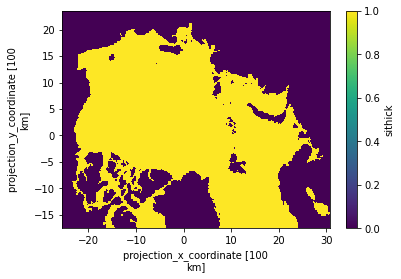

In [54]:
maskok.plot()

In [55]:
# Save maskok to netcdf for later use
# str_xy = '_'.join([f'i{item}' for item in lim_idm] + [f'j{item}' for item in lim_jdm])
str_xy = f"i{lim_idm[0]}-{lim_idm[1]}_j{lim_jdm[0]}-{lim_jdm[1]}"

filename = os.path.join(rootdir, pca_dir, f"land_mask_{str_xy}.nc")
maskok.to_netcdf(filename)

In [57]:
# Compute EOF
EOF1d, EOF2d_na = extract_pca.compute_eof(n_components, X_na, pca_na, maskok)

In [144]:
X1d_nonan.shape

(400, 76596)

In [35]:
#ntest, nval, ntrain, nsplit = tardis_ml.compute_dataset_splits(Xf1d_nonan)

# #TODO : delete entre (remplate provisoirement ligne au dessus attend import)
# nn = Xf1d_nonan.shape[0]
# #Ideally one year of validation for hyperparameter tuning and one year of test
# ntest = 365
# nval = 360 #a bit less than one year to fit one more split
# ntrain = nn - ntest - nval

# ntrain = nn - ntrain
# ntrain = 0
# # TODO : delete entre



PCs_na = xr.DataArray(pca_na.transform(X1d_nonan), dims=['time','comp'])

/cluster/home/leoede/tardis/tardis-ml/src/utils/modif_plot.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lably, fontsize = s)
/cluster/home/leoede/tardis/tardis-ml/src/utils/modif_plot.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lablx, fontsize = s)


Saved as: /nird/projects/nird/NS2993K/Leo/results/xgb_Npred22_7F_rw21d_N4444_H1333_Hn0000_sithick_noname_220928-114559/figures/sithick_PCA_noSIT_EOF_PC.png


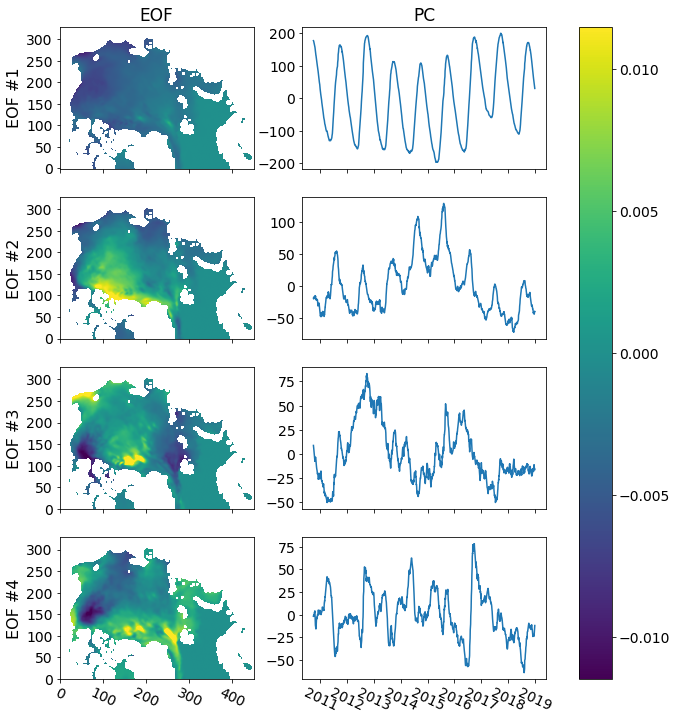

In [36]:
filename = f'{rootdir}{fig_dir}{target_field}_PCA_noSIT_EOF_PC{suffix}.png'
visualize_pca.plot_save_eof(chrono_na, 4, n_components, EOF2d_na, PCs_na, target_field, 0, ofile=filename)

/cluster/home/leoede/tardis/tardis-ml/src/utils/modif_plot.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lably, fontsize = s)


Fig saved as: /nird/projects/nird/NS2993K/Leo/results/xgb_Npred22_7F_rw21d_N4444_H1333_Hn0000_sithick_noname_220928-133655/figures/sithick_PCA_Xna_cumvar_01.png


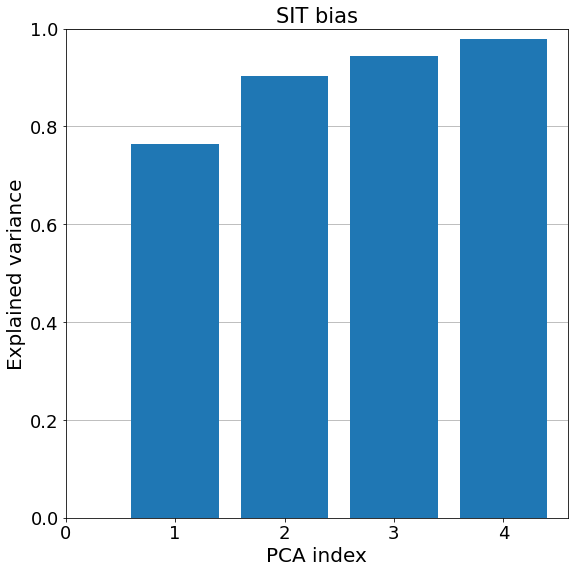

In [65]:
# Visualize cumulative explained variance of the first axes

filename = f'{rootdir}{fig_dir}{target_field}_PCA_Xna_cumvar{suffix}.png'
visualize_pca.plot_pca_variance(n_components, pca_na, target_field, True, filename)


----

### 2) PCA of SIT with sit assimilation:

In [66]:
# Compute PCA

data_kind = "withsit"
n_components = load_config.get_n_components(data_kind, file_config)
file_save = os.path.join(rootdir, pca_dir, f'pca_{target_field}_{n_components}N_SITass.pkl')

In [67]:
listfile_a = sorted(glob(os.path.join(rootdir + withsit_dir,'*.nc')))

In [106]:
nc_sel_a, chrono_a = extract_pca.load_TOPAZ(listfile_a[:400], f'{target_field}', lim_idm, lim_jdm)

Define chronology from .nc files...
Loading .nc ...
Variable selection...
Spatial selection...


In [134]:
ofile_pca = os.path.join(rootdir, pca_dir, f'pca_{target_field}_{n_components}N_SITass.pkl')
ofile_X = os.path.join(rootdir, pca_dir, f"{target_field}_TOPAZ4b.nc")
mu_a, X_a, X1d_nonan, pca_a, maskok = extract_pca.compute_pca_TOPAZ(nc_sel_a, n_components, lim_idm, lim_jdm, ofile_pca, ofile_X)

TODO : redo by combinbing forecast and analyis mask (even though they should be the same)
Compute ocean/land mask...
Todo: split between train/evaluation datasets
Compute PCA with ncomp = 4...
PCA saved: 
/nird/projects/nird/NS2993K/Leo/results/pca_i100-550_j300-629/pca_sithick_4N_SITass.pkl
PCA saved as /nird/projects/nird/NS2993K/Leo/results/pca_i100-550_j300-629/pca_sithick_4N_SITass.pkl
X saved as /nird/projects/nird/NS2993K/Leo/results/pca_i100-550_j300-629/sithick_TOPAZ4b.nc


In [108]:
# Compute EOF
EOF1d, EOF2d_a = extract_pca.compute_eof(n_components, X_a, pca_a, maskok)

In [109]:
#ntest, nval, ntrain, nsplit = tardis_ml.compute_dataset_splits(Xf1d_nonan)

# #TODO : delete entre (remplate provisoirement ligne au dessus attend import)
# nn = Xf1d_nonan.shape[0]
# #Ideally one year of validation for hyperparameter tuning and one year of test
# ntest = 365
# nval = 360 #a bit less than one year to fit one more split
# ntrain = nn - ntest - nval

# ntrain = nn - ntrain
# ntrain = 0
# # TODO : delete entre



PCs_a = xr.DataArray(pca_a.transform(X1d_nonan), dims=['time','comp'])

/cluster/home/leoede/tardis/tardis-ml/src/utils/modif_plot.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lably, fontsize = s)
/cluster/home/leoede/tardis/tardis-ml/src/utils/modif_plot.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lablx, fontsize = s)


Saved as: /nird/projects/nird/NS2993K/Leo/results/xgb_Npred22_7F_rw21d_N4444_H1333_Hn0000_sithick_noname_220928-133655/figures/sithick_PCA_SITass_EOF_PC.png


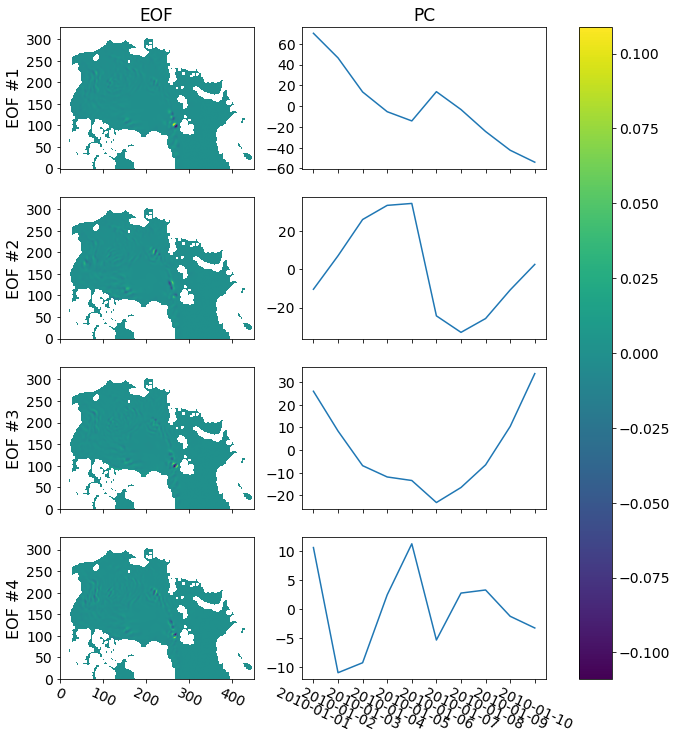

In [74]:
filename = f'{rootdir}{fig_dir}{target_field}_PCA_SITass_EOF_PC.png'
visualize_pca.plot_save_eof(chrono_a, 4, n_components, EOF2d_a, PCs_a, target_field, 0, ofile=filename)

Fig saved as: /nird/projects/nird/NS2993K/Leo/results/xgb_Npred22_7F_rw21d_N4444_H1333_Hn0000_sithick_noname_220928-133655/figures/sithick_PCA_Xa_cumvar_01.png


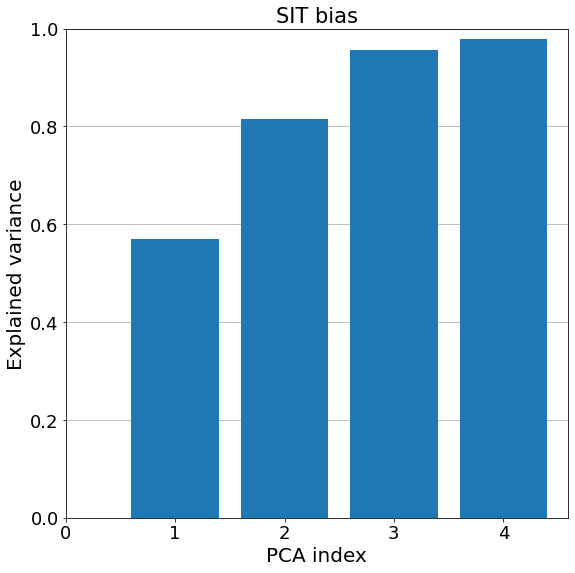

In [75]:
# Visualize cumulative explained variance of the first axes

filename = f'{rootdir}{fig_dir}{target_field}_PCA_Xa_cumvar_01.png'
visualize_pca.plot_pca_variance(n_components, pca_a, target_field, True, filename)


----

## 3) Bias between TOPAZ4b and TOPAZ4c

In [ ]:
# Need to select only the time indexes shared between the 2 datasets
# TOPAZ4b contains all 2010, TOPAZ4c contains only the ~2 last months

In [112]:
nc_sel_e = X_a - X_na

In [130]:
chrono_e = chrono_na.merge(chrono_a)  # only keep common times between 2 versions of TOPAZ

In [116]:
ofile_pca = os.path.join(rootdir, pca_dir, f'pca_{target_field}_{n_components}N_SITerr.pkl')
ofile_X = os.path.join(rootdir, pca_dir, f"{target_field}_err_TOPAZb-c.nc")
mu_e, X_e, X1d_nonan, pca_e, maskok = extract_pca.compute_pca_TOPAZ(nc_sel_e, n_components, lim_idm, lim_jdm, ofile_pca, ofile_X)

TODO : redo by combinbing forecast and analyis mask (even though they should be the same)
Compute ocean/land mask...
Todo: split between train/evaluation datasets
Compute PCA with ncomp = 4...


In [117]:
# Compute EOF
EOF1d, EOF2d_e = extract_pca.compute_eof(n_components, X_e, pca_e, maskok)

In [119]:
PCs_e = xr.DataArray(pca_e.transform(X1d_nonan), dims=['time','comp'])

 ---- Plot ----

/cluster/home/leoede/tardis/tardis-ml/src/utils/modif_plot.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lably, fontsize = s)
/cluster/home/leoede/tardis/tardis-ml/src/utils/modif_plot.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lablx, fontsize = s)


Saved as: /nird/projects/nird/NS2993K/Leo/results/xgb_Npred22_7F_rw21d_N4444_H1333_Hn0000_sithick_noname_220928-133655/figures/sithick_PCA_SITerr_EOF_PC.png


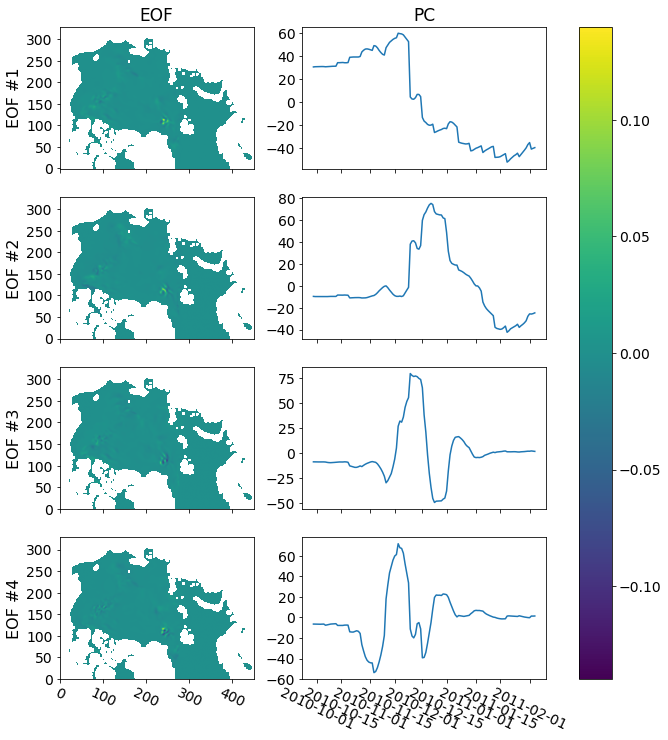

In [131]:
filename = f'{rootdir}{fig_dir}{target_field}_PCA_SITerr_EOF_PC.png'
visualize_pca.plot_save_eof(chrono_e, 8, n_components, EOF2d, PCs_e, target_field, 0, ofile=filename)

Fig saved as: /nird/projects/nird/NS2993K/Leo/results/xgb_Npred22_8F_rw21d_N4444_H1333_Hn0000_sithick_artc_220920-174631/figures/sithick_PCA_Xe_cumvar_01.png


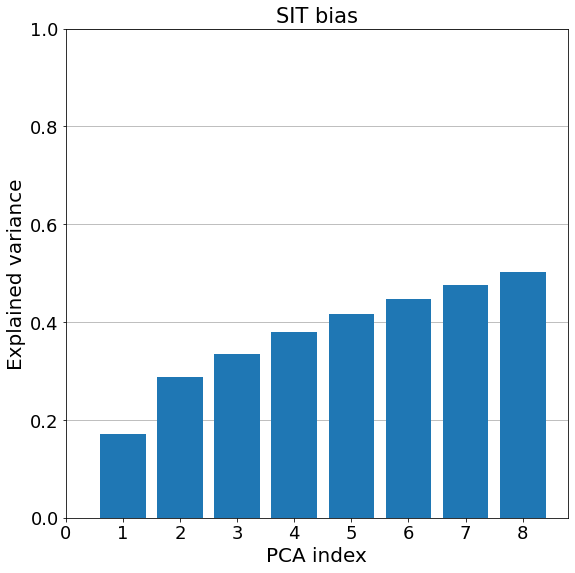

In [199]:
# Visualize cumulative explained variance of the first axes

filename = f'{rootdir}{fig_dir}{target_field}_PCA_Xe_cumvar_01.png'
visualize_pca.plot_pca_variance(n_components, pca, target_field, True, filename)


----
### Visualize results


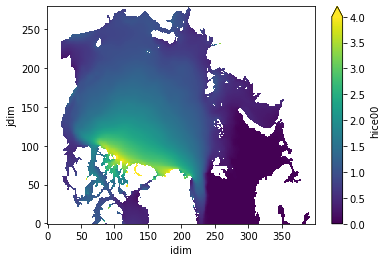

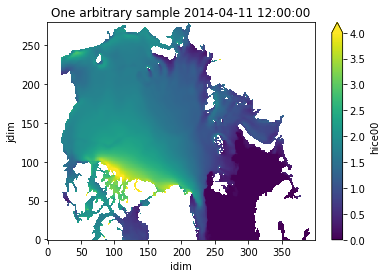

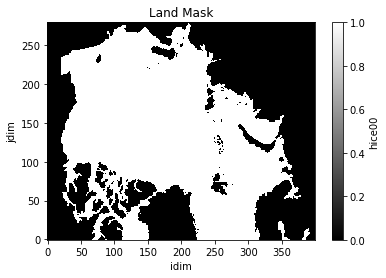

In [12]:
# Visualize some data

mu_f.plot(vmax=4);
plt.show()

Xf.isel(rdim=idate).plot(vmax=4)
plt.title(f'One arbitrary sample {chrono.iloc[idate]}');
plt.show()

maskok_f.plot(cmap=plt.get_cmap('gray'));
plt.title('Land Mask');
plt.show()

In [13]:
# plot current zone on Arctic map

_, area_name = tardisml_utils.get_area_name(lim_idm, lim_jdm)
if area_name != 'artc':
    plot_land_mask(lim_idm, lim_jdm, rootdir, pca_dir, savefig=True)
else:
    plot_land_mask(lim_idm, lim_jdm, rootdir, pca_dir, drwzne=False, savefig=True)


FileNotFoundError: [Errno 2] No such file or directory: b'/nird/projects/nird/NS2993K/Leo/results/pca_8N_i200-600_j600-881/land_mask_i200-600_j600-881.nc'

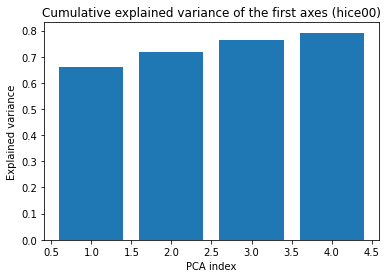

In [14]:
# Visualize cumulative explained variance of the first axes

filename = f'{rootdir}{fig_dir}{target_field}_PCA_noSIT_cumvar.png'
visualize_pca.plot_save_pca_variance(n_components, pca_f, target_field, filename)

In [76]:
#ntest, nval, ntrain, nsplit = tardis_ml.compute_dataset_splits(Xf1d_nonan)

#TODO : delete entre (remplate provisoirement ligne au dessus attend import)
nn = Xf1d_nonan.shape[0]
#Ideally one year of validation for hyperparameter tuning and one year of test
ntest = 365
nval = 360 #a bit less than one year to fit one more split
ntrain = nn - ntest - nval

ntrain = nn - ntrain
ntrain = 0
# TODO : delete entre



PCs_f = xr.DataArray(pca_f.transform(Xf1d_nonan), dims=['rdim','comp'])

In [87]:
filename = f'{rootdir}{fig_dir}{target_field}_PCA_noSIT_EOF_PC.png'
visualize_pca.plot_save_eof(chrono, 4, n_components, EOF2d, PCs_f, target_field, ntrain, ofile=filename)

NameError: name 'PCs_f' is not defined

In [81]:
# Reconstruction TODO use inverse transform/kernel PCA ?
Xf_rec = xr.dot(EOF2d,PCs_f)+ mu_f

# Reconstruction 3 EOF
Xf_rec3 = xr.dot(EOF2d.isel(comp=slice(0,3)),PCs_f.isel(comp=slice(0,3))) + mu_f

In [85]:
filename = f'{rootdir}{fig_dir}REC_TOPAZ_{target_field}_diff.png'

visualize_pca.plot_save_reconstruction_eof(chrono, idate, Xf, Xf_rec, ntrain, filename)

Saved as /nird/projects/nird/NS2993K/Leo/results/rf_Npred22_8F_rw21d_N4444_H1333_Hn0000_hice00_artc_220824-091938/figures/REC_TOPAZ_hice00_diff.png


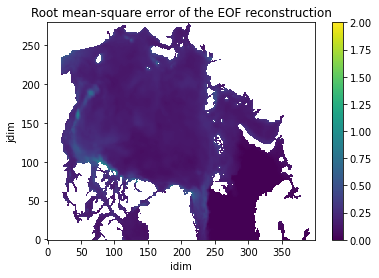

In [29]:
RMSE_recf = np.sqrt((np.square(Xf_rec-Xf[ntrain:])).mean(dim='rdim'))

RMSE_recf.plot(vmax=2)
plt.title('Root mean-square error of the EOF reconstruction');
#filename = f'RMSE_EOF_rec.png'
#plt.savefig(f"{rootdir}{fig_dir}{filename}")

### 2) PCA of SIT with sit assimilation (reference field)
Actually we don't represent the PCA of the SIT field but the PCA of the difference between SIT (with DA) and SIT (no DA), called 'model error'

In [64]:
data_kind = "withsit"
n_components = 8  #load_config.get_n_components(data_kind, file_config)
#file_sit_assimilate = os.path.join(tardisml_utils.rootdir, pca_dir, f"{target_field}_forecast_SITass.nc")
#filename = os.path.join(rootdir,pca_dir,f'pca_{target_field}_{n_components}N_SITerr.pkl')  # SITass-SITnoass

mu_a, Xa, Xa1d_nonan, pca_a, maskok_a, nc_a = feature_pca.compute_pca(chrono, n_components, withsit_dir, target_field, lim_idm, lim_jdm, template, '', nc_f, pca_dir, maskok_f)

TODO : redo by combinbing forecast and analyis mask (even though they should be the same)


In [13]:
# Save Xa to netcdf for retrieve PC and EOF later

filename = os.path.join(rootdir,pca_dir,f"{target_field}_forecast_SITerr.nc")
Xa.to_netcdf(filename)
print(f'SIT err saved in: {filename}')

PermissionError: [Errno 13] Permission denied: b'/nird/projects/nird/NS2993K/Leo/results/pca_i200-600_j600-881/hice00_forecast_SITerr.nc'

----
### Visualize results


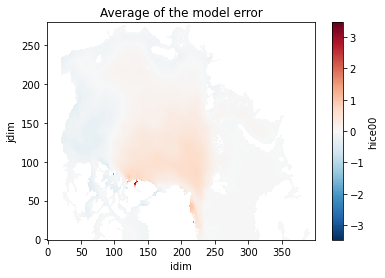

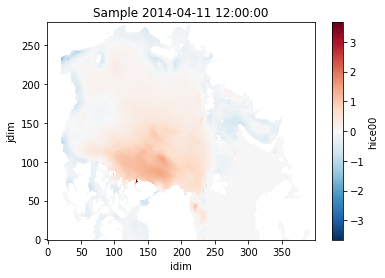

In [32]:
mu_a.plot()
plt.title('Average of the model error')
plt.show()

Xa.isel(rdim=idate).plot()
plt.title(f'Sample {chrono.iloc[idate]}');
plt.show()

model error corresponds to (Sea Ice thickness) assimilated - forecast\
it shows the biais of the model and the possibility to correct those systematics errors using machine learning

The model error shows higher RMSE in comparison to the RMSE of the EOF reconstruction.
This suggests that the EOF method is able to give smaller errors than the model, and therefore can be used as a statistical correction method.

In [33]:
visualize_pca.plot_save_pca_variance(n_components, pca_a, target_field, "")

In [65]:
EOF1d_a, EOF2d_a = feature_pca.compute_eof(n_components, Xa, pca_a, maskok_a)

In [66]:
PCs_a = xr.DataArray(pca_a.transform(Xa1d_nonan), dims=['rdim','comp'])

In [91]:
from importlib import reload
reload(visualize_error);

/cluster/home/leoede/tardis/tardis-ml/src/utils/modif_plot.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lably, fontsize = s)
/cluster/home/leoede/tardis/tardis-ml/src/utils/modif_plot.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lablx, fontsize = s)


Saved as: /nird/projects/nird/NS2993K/Leo/results/rf_Npred22_8F_rw21d_N4444_H1333_Hn0000_hice00_artc_220824-091938/figures/hice00_PCA_withSIT_EOF_PC_01.png


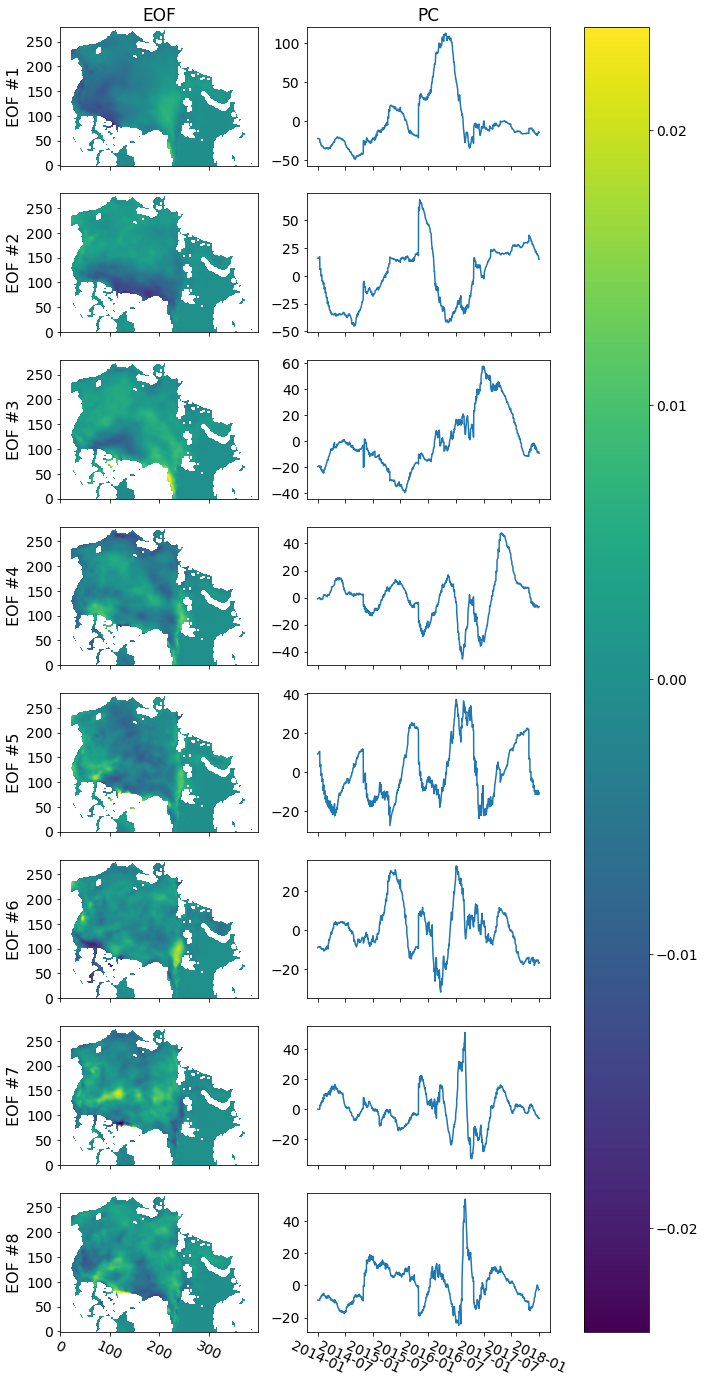

In [67]:
filename = f'{rootdir}{fig_dir}{target_field}_PCA_withSIT_EOF_PC_01.png'
visualize_pca.plot_save_eof(chrono, 8, n_components, EOF2d_a, PCs_a, target_field, 0, ofile=filename)

Fig saved as: /nird/projects/nird/NS2993K/Leo/results/rf_Npred22_8F_rw21d_N4444_H1333_Hn0000_hice00_artc_220824-091938/figures/hice00_PCA_Xe_cumvar_01.png


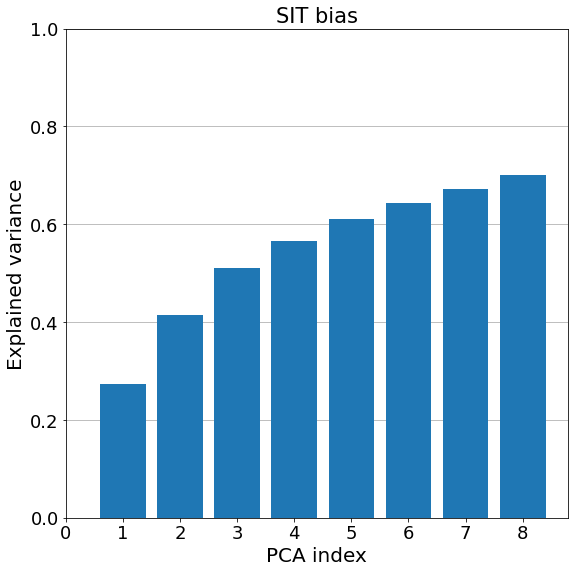

In [69]:
# Visualize cumulative explained variance of the first axes

filename = f'{rootdir}{fig_dir}{target_field}_PCA_Xe_cumvar_01.png'
visualize_pca.plot_pca_variance(n_components, pca_a, target_field, True, filename)


In [72]:
# Reconstruction
Xa_rec = xr.dot(EOF2d_a,PCs_a)+ mu_a

In [92]:
filename = f"{rootdir}{fig_dir}RMSE_model_error_EOF_rec_true.png"
visualize_error.plot_rmse(Xf, Xf_rec, Xa, Xa_rec, ntrain, filename=filename)

Average of the model error: <xarray.DataArray 'hice00' ()>
array(0.2895862, dtype=float32)
Average of the model error reconstruction:<xarray.DataArray ()>
array(0.12947517)
Saved as: /nird/projects/nird/NS2993K/Leo/results/rf_Npred22_8F_rw21d_N4444_H1333_Hn0000_hice00_artc_220824-091938/figures/RMSE_model_error_EOF_rec_true.png


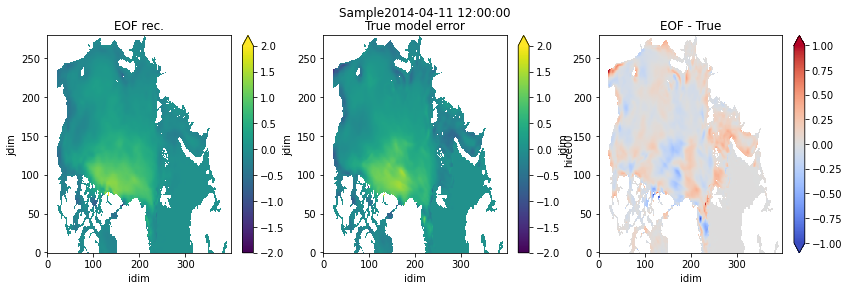

In [94]:
fig, ax = plt.subplots(ncols=3, figsize=(14,4))
fig.suptitle(f'Sample{chrono.iloc[idate]}')

Xa_rec.isel(rdim=idate).plot(ax=ax[0],vmin=-2, vmax=2)
Xa.isel(rdim=idate).plot(ax=ax[1],vmin=-2, vmax=2)
(Xa_rec-Xa).isel(rdim=idate).plot(ax=ax[2], vmin=-1, vmax=1, cmap=plt.get_cmap('coolwarm'))
ax[0].set_title('EOF rec.')
ax[1].set_title('True model error')
ax[2].set_title('EOF - True')

filename = f'RMSE_EOF_rec_diff_True.png'
plt.savefig(f"{rootdir}{fig_dir}{filename}")


In [95]:
print(f"{rootdir}{fig_dir}{filename}")

/nird/projects/nird/NS2993K/Leo/results/rf_Npred22_8F_rw21d_N4444_H1333_Hn0000_hice00_artc_220824-091938/figures/RMSE_EOF_rec_diff_True.png


----

----

## 3) Bias of ASS - no ASS (TOPAZ4b - TOPAZ4c)

In [168]:
filename = os.path.join(rootdir, pca_dir, f"{target_field}_forecast_noSITass.nc")
Xf = load_data.load_nc(filename, 'sithick', True)

In [169]:
filename = os.path.join(rootdir, pca_dir, f"{target_field}_forecast_SITass.nc")
Xa = load_data.load_nc(filename, 'sithick', True)

In [170]:
Xfm = Xf.mean(dim=('y','x')).compute()
Xam = Xa.mean(dim=('y','x')).compute()

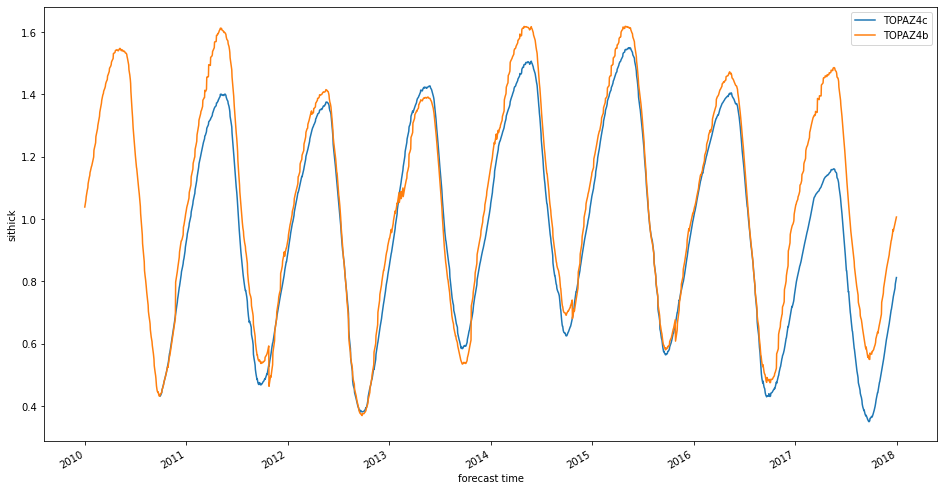

In [186]:
fig, ax = plt.subplots(figsize=(16, 8))
Xfm.plot(label='TOPAZ4c')
Xam.plot(label='TOPAZ4b')
plt.legend()

In [201]:
from src.utils import modif_plot

In [222]:
rootdir

'/nird/projects/nird/NS2993K/'

In [221]:
fig_dir

'Leo/results/xgb_Npred22_8F_rw21d_N4444_H1333_Hn0000_sithick_artc_220920-174631/figures/'

Saved as /nird/projects/nird/NS2993K/Leo/results/xgb_Npred22_8F_rw21d_N4444_H1333_Hn0000_sithick_artc_220920-174631/figures/TOPAZ4b_c_bias.png


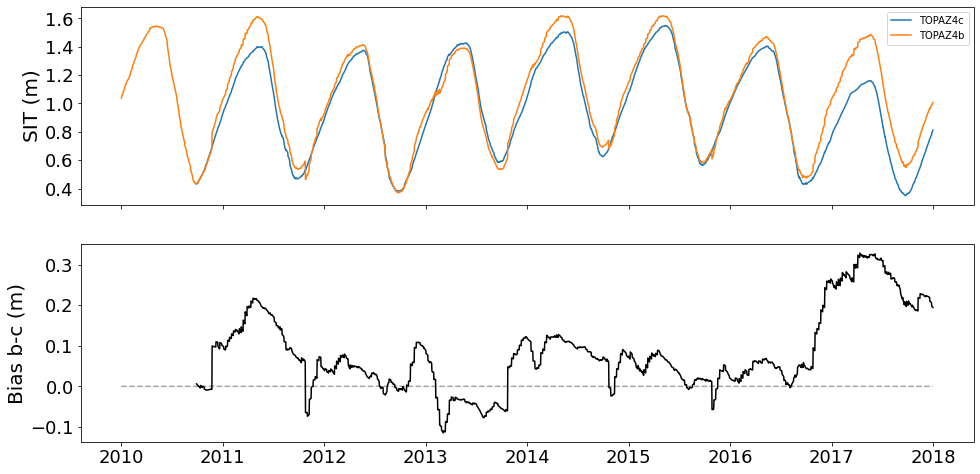

In [223]:
fig, (ax, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(16, 8))
ax.plot(chrono, Xfm, label='TOPAZ4c')
ax.plot(chrono_w, Xam, label='TOPAZ4b')
ax.set_ylabel('SIT (m)')
ax.set_xticklabels('')

ax2.plot(chrono_w, [0]*len(chrono_w), '--', c ='grey', alpha=.7)
ax2.plot(chrono, Xem, 'k')
ax2.set_xlim(ax.get_xlim())
ax2.set_ylabel(f'Bias b-c (m)')


ax.legend()

modif_plot.resize(fig, s=18)

savefig = True
if savefig:
    filename = f'TOPAZ4b_c_bias.png'
    plt.savefig(f"{rootdir}{fig_dir}{filename}")
    print(f'Saved as {rootdir}{fig_dir}{filename}')

In [172]:
Xem = Xam - Xfm

In [174]:
Xe = Xa - Xf

In [175]:
Xe.shape

(2651, 329, 450)

In [187]:
n_components = 8

In [188]:
maskok = (np.isfinite(Xe)).all(dim='time')
mskok1d= maskok.stack(z=('y','x'))
           
X1d =  Xe.stack(z=('y','x'))
X1d_nonan = X1d.where(mskok1d, drop=True)

In [192]:
pca = PCA(n_components=n_components).fit(X1d_nonan)

In [193]:
file_save = os.path.join(rootdir, pca_dir, f'pca_{target_field}_{n_components}N_SITerr.pkl')
save_pca(file_save, pca)

PCA saved: 
/nird/projects/nird/NS2993K/Leo/results/pca_i200-600_j600-881/pca_sithick_8N_SITerr.pkl


In [181]:
# Save Xf to netcdf for retrieve PC and EOF later
filename = os.path.join(rootdir, pca_dir, f"{target_field}_forecast_SITerr.nc")
Xe.to_netcdf(filename)

In [194]:
# Compute EOF
EOF1d, EOF2d = compute_eof(n_components, Xe, pca, maskok)

In [195]:
PCs_e = xr.DataArray(pca.transform(X1d_nonan), dims=['time','comp'])

Saved as: /nird/projects/nird/NS2993K/Leo/results/xgb_Npred22_8F_rw21d_N4444_H1333_Hn0000_sithick_artc_220920-174631/figures/sithick_PCA_SITerr_EOF_PC.png


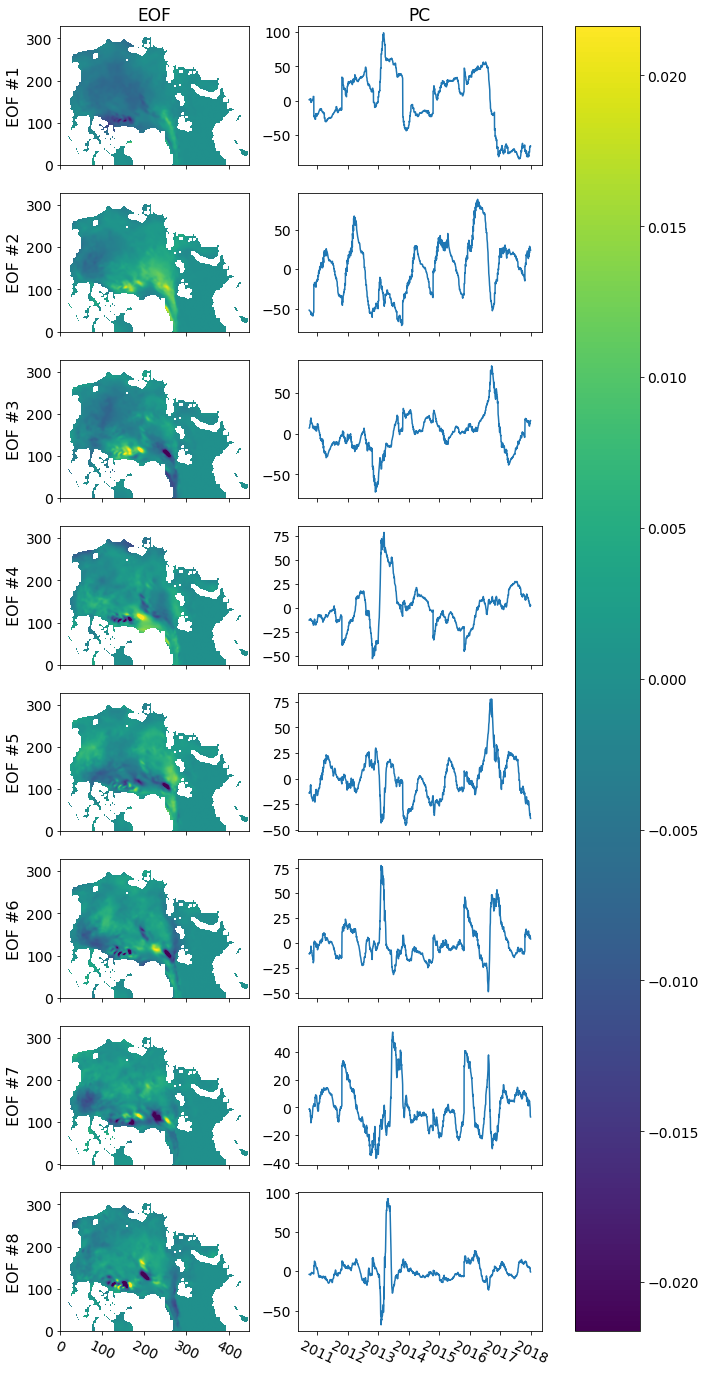

In [197]:
filename = f'{rootdir}{fig_dir}{target_field}_PCA_SITerr_EOF_PC.png'
visualize_pca.plot_save_eof(chrono, 8, n_components, EOF2d, PCs_e, target_field, 0, ofile=filename)

Fig saved as: /nird/projects/nird/NS2993K/Leo/results/xgb_Npred22_8F_rw21d_N4444_H1333_Hn0000_sithick_artc_220920-174631/figures/sithick_PCA_Xe_cumvar_01.png


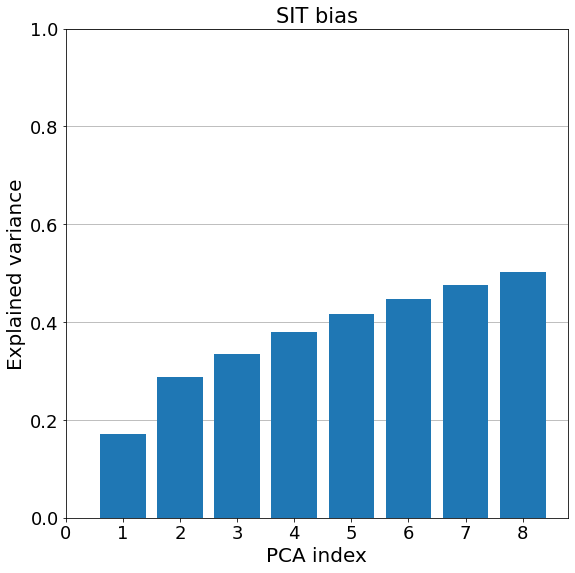

In [199]:
# Visualize cumulative explained variance of the first axes

filename = f'{rootdir}{fig_dir}{target_field}_PCA_Xe_cumvar_01.png'
visualize_pca.plot_pca_variance(n_components, pca, target_field, True, filename)


----

## PCA of the forcings

In [8]:
forcing_bdir_old = 'Leo/forcings'

In [12]:
df = pd.read_pickle(os.path.join(rootdir,forcing_bdir_old,f'mslprs.pkl'))
chrono_old = df[df.time%1==timeofday].date

In [20]:
chrono_old.iloc[0]

Timestamp('2014-01-01 12:00:00')

In [7]:
data_kind = "forcing"
n_components = load_config.get_n_components(data_kind, file_config)
# n_components = .95
forcings, Nf, chrono = load_data.load_forcing(forcing_fields, forcing_bdir, return_chrono=True)
# forcings, Nf = load_data.load_forcing(forcing_fields[:1], forcing_bdir)

-----

-----

In [8]:
from src.data_preparation import mdl_dataset_prep


### NEW CLEAN

In [9]:
sav = forcings.copy()

In [10]:
forcings['2T_mean15d'].shape

(3652, 329, 450)

In [11]:
maskok = load_data.load_land_mask(lim_idm, lim_jdm, rootdir, pca_dir)
mskok1d = maskok.stack(z=('y','x'))

In [12]:
# for each forcing:
# inverse latitude
for forcing in forcing_fields:
     forcings[forcing][:] = forcings[forcing][:][::-1]

In [13]:
# ---------- selection ntrain ---------- 
ntrain, nval, ntest = mdl_dataset_prep.dataset_split(forcings[forcing_fields[0]].shape[0])
suffix = '_train'
chrono = chrono[ntest+nval:]
for forcing in forcing_fields:
    forcings[forcing] = forcings[forcing][ntest+nval:]     


In [14]:
forcings2d = forcings.copy()
# stack lat and lon dimensions
# apply mask to exclude values not over sea-ice
# ---------- apply mask ---------- 
print('Apply land/ocean mask...')
for forcing in forcing_fields:
    tmp2D = xr.DataArray(forcings2d[forcing].reshape(forcings2d[forcing].shape[0], -1), dims=('time', 'z'))
    tmp2D_nonan = tmp2D.where(mskok1d, drop=True)
    forcings2d[forcing] = tmp2D_nonan.to_numpy()

Apply land/ocean mask...


In [22]:
odir = f'{rootdir}{pca_dir}/'
mu, pca, PCs, EOFs = feature_pca.compute_pca_forcing(n_components, forcing_fields, forcings2d)

2T_mean15d
# TODO train/val
MSL_mean15d
# TODO train/val
10V_mean15d
# TODO train/val
10U_mean15d
# TODO train/val
TP_mean15d
# TODO train/val
SSR_mean15d
# TODO train/val
STR_mean15d
# TODO train/val


In [23]:
pca['2T_mean15d'].components_.shape

(4, 76596)

In [21]:
forcings['2T_mean15d'].shape

(2921, 329, 450)

In [30]:
EOF2D = {}
for forcing in forcing_fields[:1]:
#     X = xr.DataArray(forcings[forcing][ntest+nval:, :], dims=('time', 'y', 'x')).where(maskok, drop=False)
    X = xr.DataArray(forcings[forcing], dims=('time', 'y', 'x')).where(maskok, drop=False)
    _, EOF2D[forcing] = extract_pca.compute_eof(n_components, X, pca[forcing], maskok)

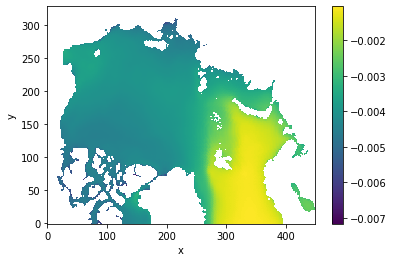

In [29]:
EOF2D['2T_mean15d'][0].plot()

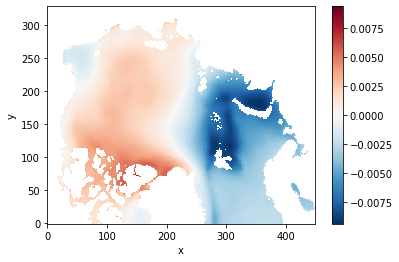

In [32]:
EOF2D['2T_mean15d'][1].plot()

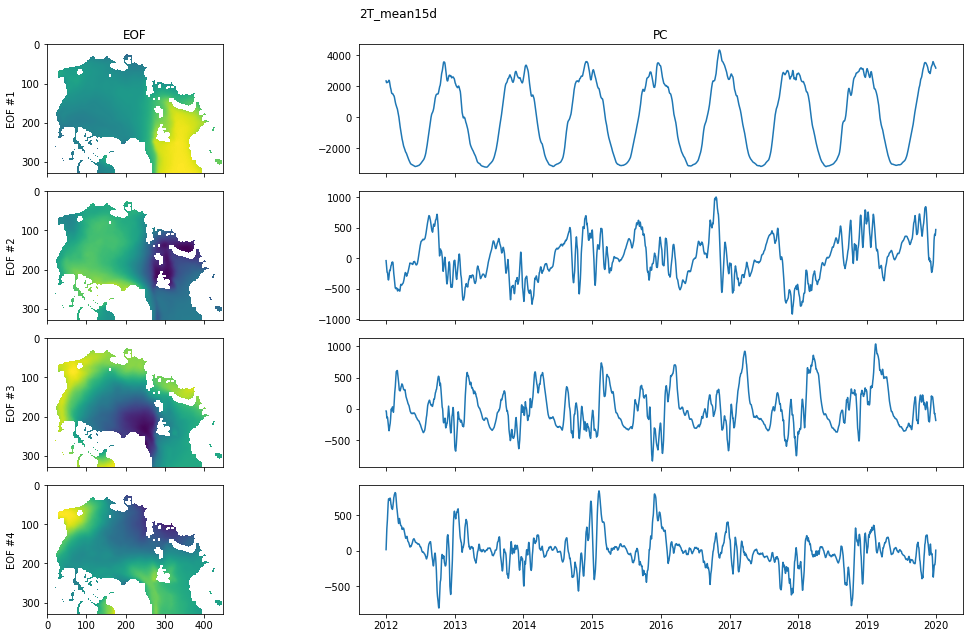

In [46]:
for field in forcing_fields[:1]:
    filename = f'{rootdir}{fig_dir}forcing_{field}_EOF{suffix}.png'
    visualize_pca.plot_eof2D(chrono, EOF2D[field], PCs[field], field, ofile='',showfig=True)

In [15]:
chrono = pd.to_datetime(chrono)

In [ ]:
forcings_ori = sav.copy()

---------

---------

---------

In [44]:
from importlib import reload
reload(visualize_pca);

login-2.fram.sigma2.no
fram detected


---------

### no CLEAN

In [8]:
sav = forcings.copy()

In [37]:
forcings['2T_mean15d'].shape

(3652, 329, 450)

In [9]:
maskok = load_data.load_land_mask(lim_idm, lim_jdm, rootdir, pca_dir)
mskok1d = maskok.stack(z=('y','x'))

In [ ]:
# inverse latitude
# stack lat and lon dimensions
# apply mask

In [10]:
for forcing in forcing_fields[:1]:
#     forcings[forcing][:] = forcings[forcing][:][::-1]
#     tmp = xr.DataArray(forcings[forcing], dims=('time', 'y', 'x'))
    tmp2D = xr.DataArray(forcings[forcing][:,::-1].reshape(forcings[forcing].shape[0], -1), dims=('time', 'z'))
    tmp2D_nonan = tmp2D.where(mskok1d, drop=True)
    forcings[forcing] = tmp2D_nonan.to_numpy()


In [12]:
from src.data_preparation import mdl_dataset_prep


In [13]:
ntrain, nval, ntest = mdl_dataset_prep.dataset_split(forcings[forcing_fields[0]].shape[0])
suffix = '_train'
chrono = chrono[ntest+nval:]
for forcing in forcing_fields:
    forcings[forcing] = forcings[forcing][ntest+nval:]

In [87]:
odir = f'{rootdir}{pca_dir}/'
mu, pca, PCs, EOFs = feature_pca.compute_pca_forcing(n_components, forcing_fields, forcings)

2T_mean15d
# TODO train/val
MSL_mean15d
# TODO train/val
10V_mean15d
# TODO train/val
10U_mean15d
# TODO train/val
TP_mean15d
# TODO train/val
SSR_mean15d
# TODO train/val
STR_mean15d
# TODO train/val


In [15]:
chrono = pd.to_datetime(chrono)

In [ ]:
forcings_ori = sav.copy()

In [197]:
EOF2D = {}
for forcing in forcing_fields[:1]:
    X = xr.DataArray(forcings_ori[forcing][ntest+nval:, :], dims=('time', 'y', 'x')).where(maskok, drop=False)
#     print(X.shape)
#     break
    _, EOF2D[forcing] = extract_pca.compute_eof(n_components, X, pca[forcing], maskok)

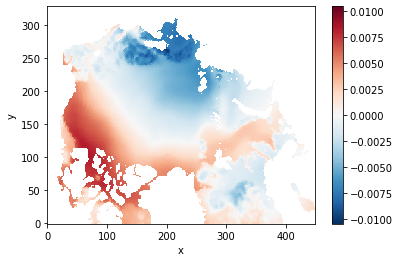

In [204]:
EOF2D['2T_mean15d'][0].plot()

------------

Draft

In [93]:
forcings_ori = sav.copy()

In [111]:
forcings_ori['2T_mean15d'][ntest+nval:, ::-1].shape

(2921, 329, 450)

In [110]:
maskok.shape

(329, 450)

In [132]:
forcings[forcing].shape

(2921, 329, 450)

In [133]:
X2d = xr.DataArray(forcings[forcing_fields[0]][ntest+nval:, ::-1], dims=('time', 'y', 'x')) # .where(maskok, drop=True)

ValueError: different number of dimensions on data and dims: 2 vs 3

In [114]:
Xcor = xr.DataArray(forcings_ori[forcing_fields[0]][ntest+nval:, ::-1], dims=('time', 'y', 'x')) # .where(maskok, drop=True)

In [140]:
Xm = Xcor.where(maskok, drop=False)

In [141]:
Xm1d = Xm[0].stack(z=('y','x'))

In [139]:
Xm1d.shape

(134663,)

In [142]:
Xm1d.shape

(148050,)

In [143]:
Xm1d

<xarray.DataArray (z: 148050)>
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
  * z        (z) MultiIndex
  - y        (z) int64 0 0 0 0 0 0 0 0 0 ... 328 328 328 328 328 328 328 328 328
  - x        (z) int64 0 1 2 3 4 5 6 7 8 ... 441 442 443 444 445 446 447 448 449

In [144]:
mskok1d = maskok.stack(z=('y','x'))

In [145]:
mskok1d.shape

(148050,)

In [147]:
EOF1d[{'z':mskok1d}] = pcaf.components_

In [165]:
pca[forcing].components_.shape

(4, 148050)

In [166]:
pca['2T_mean15d'].components_.shape

(4, 76596)

In [168]:
pca['MSL_mean15d'].components_.shape

(4, 148050)

In [170]:
forcing_fields[:1]

['2T_mean15d']

In [187]:
EOF2D = {}
for forcing in forcing_fields[:1]:
    X = xr.DataArray(forcings_ori[forcing][ntest+nval:, :], dims=('time', 'y', 'x')).where(maskok, drop=False)
#     print(X.shape)
#     break
    _, EOF2D[forcing] = extract_pca.compute_eof(n_components, X, pca[forcing], maskok)

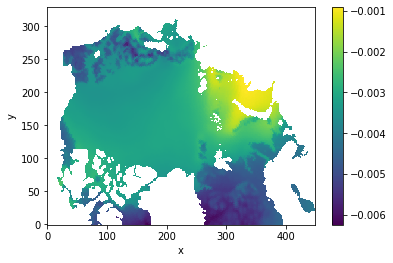

In [188]:
EOF2D['2T_mean15d'][0].plot()

-------

In [18]:
sav[forcing_fields[0]].shape

(3652, 329, 450)

In [19]:
latdim = sav[forcing_fields[0]].shape[1]
londim = sav[forcing_fields[0]].shape[2]

In [24]:
EOFs['2T_mean15d'].shape

(4, 76596)

In [75]:
X = sav['2T_mean15d'][ntest+nval:, ::-1].copy()

In [76]:
X = xr.DataArray(X, dims=('time', 'y', 'x'))

In [29]:
pca = PCs['2T_mean15d'].copy()

In [48]:
pca.shape

(2921, 4)

In [123]:
X1d = X.stack(z=('y','x'))
mskok1d = maskok.stack(z=('y','x'))

EOF1d = xr.DataArray(np.nan*np.ones ((n_components,X1d.shape[1])),dims=['comp','z'])
multi_index = pd.MultiIndex.from_tuples(X1d.coords['z'].data,names=['y','x'])
EOF1d = EOF1d.assign_coords(z=('z',multi_index))
EOF1d[{'z':mskok1d}] = pcaf.components_
EOF2d = EOF1d.unstack('z')

In [129]:
pcaf.components_.shape

(4, 76596)

In [128]:
pca['2T_mean15d'].components_.shape

(4, 76596)

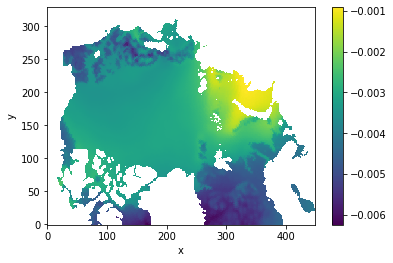

In [86]:
EOF2d[0].plot()

In [78]:
pca_p = PCA(n_components=4)

In [84]:
pcaf = pca_p.fit(forcings[forcing_fields[0]][:])

In [63]:
pcaf.components_.shape

(4, 76596)

In [55]:
pca.shape

(2921, 4)

In [64]:
EOF1d[{'z':mskok1d}] = pcaf.components_

In [148]:
EOF2d = EOF1d.unstack('z')

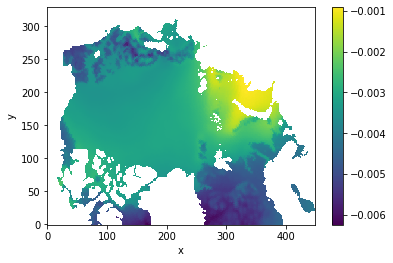

In [150]:
EOF2d[0].plot()

ValueError: cannot reshape array of size 76596 into shape (329,450)

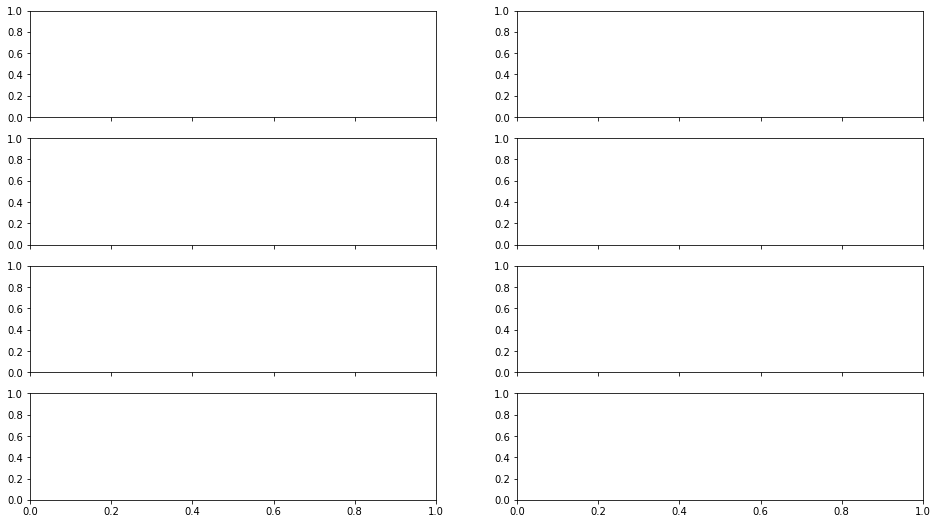

In [20]:
for field in forcing_fields:
    filename = f'{rootdir}{fig_dir}forcing_{field}_EOF{suffix}.png'
    visualize_pca.plot_save_eof_np(chrono, n_components, n_components, EOFs[field], PCs[field], 
                  latdim,
                  londim,
                  field, 0,
                  ofile=filename)

### get values only over sea ice and only for training

In [17]:
import netCDF4

In [14]:
# get filename for corresponding area
str_xy = f"i{lim_idm[0]}-{lim_idm[1]}_j{lim_jdm[0]}-{lim_jdm[1]}"
    
# open file in PCA in subfolder 
filename = os.path.join(rootdir,pca_dir,f"land_mask_{str_xy}.nc")

In [26]:
nc = netCDF4.Dataset(filename, mode='r')
# maskok = nc['sithick'][::-1]

In [76]:
maskok = xr.DataArray(nc['sithick'][:]>0, dims=('y', 'x'))

In [77]:
maskok

<xarray.DataArray (y: 329, x: 450)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Dimensions without coordinates: y, x

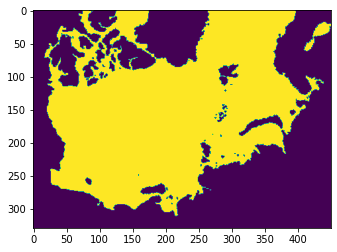

In [78]:
plt.imshow(maskok)

----

In [8]:
sav = forcings.copy()

In [83]:
forcings['2T_mean15d'].shape

(3652, 329, 450)

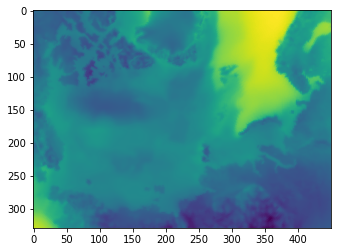

In [67]:
plt.imshow(forcings['2T_mean15d'][0])

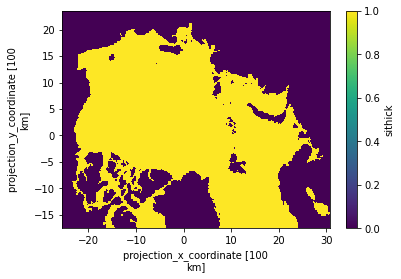

In [85]:
maskok.plot()

In [53]:
forcings['2T_mean15d'][0] = forcings['2T_mean15d'][0][::-1]

In [54]:
tt = xr.DataArray(forcings['2T_mean15d'][0], dims=('y', 'x'))

In [55]:
ttmask = tt.where(maskok, drop=True)

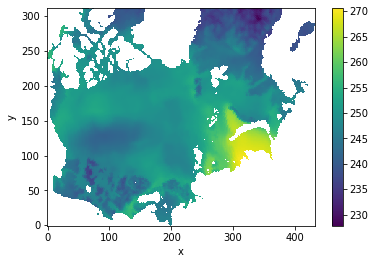

In [56]:
ttmask.plot()

In [67]:
forcings['2T_mean15d'][0, maskok]

array([244.98243713, 246.20388794, 247.97093201, ..., 245.29910278,
       246.52314758, 246.39460754])

In [103]:
# for the whole dict

In [84]:
# inverse latitude to get it correctly
forcings['2T_mean15d'][:] = forcings['2T_mean15d'][:][::-1]

In [29]:
maskok.shape

(329, 450)

In [60]:
forcings['2T_mean15d'].shape

(3652, 329, 450)

In [79]:
maskok3d = maskok.expand_dims({'time':forcings['2T_mean15d'].shape[0]})

In [80]:
maskok3d.shape

(3652, 329, 450)

In [91]:
maskok.shape

(329, 450)

In [85]:
# create DataArray to apply mask
tmp = xr.DataArray(forcings['2T_mean15d'], dims=('time', 'y', 'x'))
forcings['2T_mean15d'] = tmp.where(maskok, drop=True)

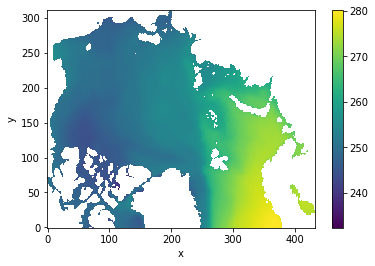

In [97]:
forcings['2T_mean15d'][2580].plot()

In [89]:
forcings['2T_mean15d'][0].to_numpy()

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [34]:
from src.data_preparation import mdl_dataset_prep

In [36]:
mdl_dataset_prep.dataset_split(forcings['2T_mean15d'].shape[0])

(2921, 0, 731)

----------------

In [ ]:
mu, pca, PCs, EOFs = feature_pca.compute_pca_forcing(n_components, forcing_fields, forcings)

In [14]:
chrono = np.load('/nird/projects/nird/NS2993K/Leo/forcings_full/chrono_forcings.npy')

In [21]:
chrono

array(['2010-01-01T12:00:00.000000000', '2010-01-02T12:00:00.000000000',
       '2010-01-03T12:00:00.000000000', ...,
       '2019-12-29T12:00:00.000000000', '2019-12-30T12:00:00.000000000',
       '2019-12-31T12:00:00.000000000'], dtype='datetime64[ns]')

In [23]:
chrono2 =  pd.to_datetime(chrono)

In [25]:
chrono2[0]

Timestamp('2010-01-01 12:00:00')

In [ ]:
for i, field in enumerate(forcing_fields):
    visualize_pca.plot_pca_variance(n_components, pca[field], field, True, "")

In [ ]:
ntrain = 0

In [ ]:
for field in forcing_fields:
    filename = f'{rootdir}{fig_dir}forcing_{field}_EOF.png'
    visualize_pca.plot_save_eof_np(chrono, 4, n_components, EOFs[field], PCs[field], 
                  len(forcings[forcing_fields[0]][0][:, 0]),
                  len(forcings[forcing_fields[0]][0][0, :]),
                  field, ntrain,
                  ofile=filename)

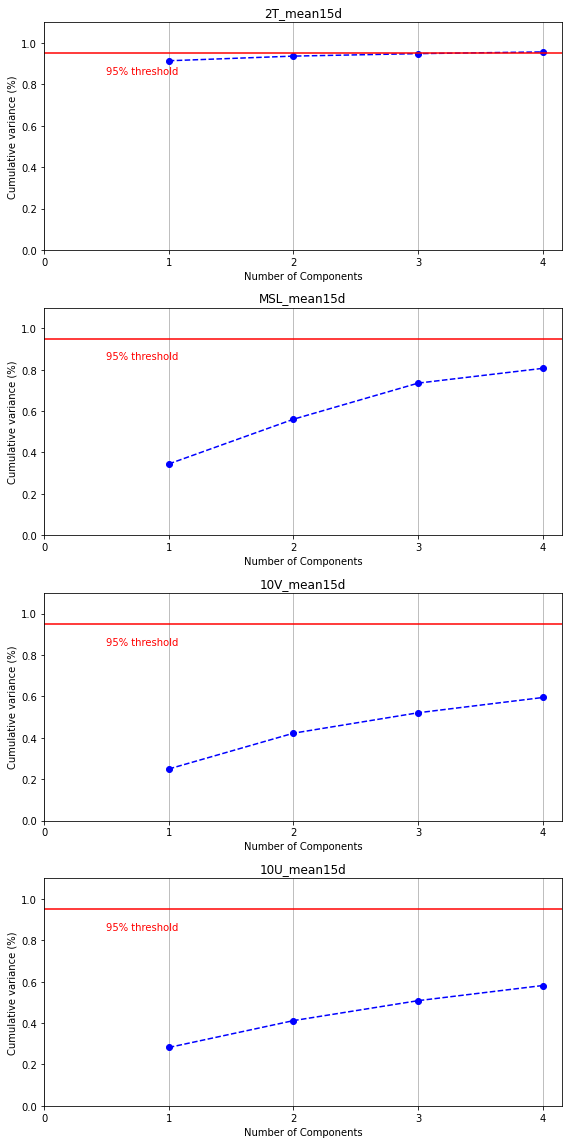

Fig saved as: /nird/projects/nird/NS2993K/Leo/results/xgb_Npred22_7F_rw15d_N8844_H1333_Hn0000_sithick_noname/figures/forcings_Ncomp_variance.png


In [34]:
filename = f"{rootdir}{fig_dir}forcings_Ncomp_variance.png"
visualize_pca.plot_ncomp_var(pca, forcing_fields, True, filename)

In [ ]:
# save PCA to files for futher use
#field_str = '-'.join(config['forcing_fields'])
#filename = os.path.join(rootdir,pca_dir,f"pca_{field_str}_{n_components}N_{config['forcing_mean_days']}d.pkl")
#print(f'PCA Forcings saved: {filename}')
#pkl.dump(pca, open(filename,"wb"))

In [ ]:
# later reload the pickle file
# pca_reload = pkl.load(open(filename,'rb'))
# pca_reload

# Feature Extraction for any covariable

### PCA of covar with no sit assimilation:

In [58]:
# Compute PCA and save
data_kind = "covariable"
n_components = load_config.get_n_components(data_kind, file_config)

In [59]:
# save for plot
PCA_co = {}

In [60]:
for covar in covar_fields:
    print(covar)
    ofile = os.path.join(rootdir, pca_dir, f'pca_{covar}_{n_components}N_noSITass.pkl')
    mu_co, Xco, Xco1d_nonan, pca_co, maskok_co, nc_co = feature_pca.compute_pca(chrono, n_components, nosit_dir, covar, lim_idm, lim_jdm, template, file_save=ofile)    

    PCA_co[covar] = pca_co  # for plot_ncomp_var()
    
    # Save Xf to netcdf for retrieve PC and EOF later
    filename = os.path.join(rootdir, pca_dir, f"{covar}_forecast_noSITass.nc")
    Xco.to_netcdf(filename)

fice00
TODO : redo by combinbing forecast and analyis mask (even though they should be the same)
PCA saved: 
/nird/projects/nird/NS2993K/Leo/results/pca_i200-600_j600-881/pca_fice00_8N_noSITass.pkl
hsnw00
TODO : redo by combinbing forecast and analyis mask (even though they should be the same)
PCA saved: 
/nird/projects/nird/NS2993K/Leo/results/pca_i200-600_j600-881/pca_hsnw00_8N_noSITass.pkl


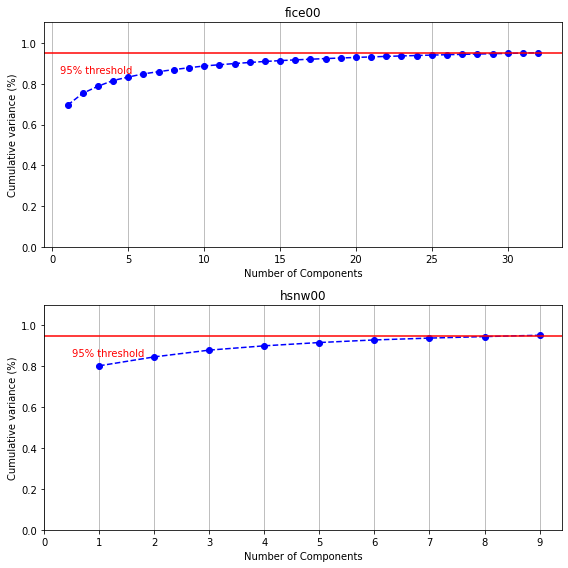

Fig saved as: /nird/projects/nird/NS2993K/Leo/results/grdbst_Npred100_4F_rw21d_N4444_H4411_Hn0000_hice00_artc/figures/covar_Ncomp_variance.png


In [38]:
filename = f"{rootdir}{fig_dir}covar_Ncomp_variance.png"
visualize_pca.plot_ncomp_var(PCA_co, covar_fields, True, filename)

------

## new topaz

In [8]:
from src.data_preparation import mdl_dataset_prep


In [20]:
from importlib import reload
reload(visualize_pca);

login-2.fram.sigma2.no
fram detected


In [12]:
covar = covar_fields[0]

In [13]:
covar_fields

['siconc', 'sisnthick', 'zos', 'vxsi', 'vysi']

In [10]:
# save for plot
PCA_co = {}
EOF2d_co = {}
PCs_co = {}

# test_limit = 10

data_kind = "covariable"
n_components = load_config.get_n_components(data_kind, file_config)
suffix = '' # on whole dataset


listfile_co = sorted(glob(os.path.join(rootdir + withsit_dir,'*.nc')))

for covar in covar_fields[:1]:
    print(f'\n{covar}')
    # load dataset
    nc_sel_co, chrono_co = extract_pca.load_TOPAZ(listfile_co, f'{covar}', lim_idm, lim_jdm)
#     nc_sel_co, chrono_co = extract_pca.load_TOPAZ(listfile_co[:test_limit], f'{covar}', lim_idm, lim_jdm)

    # split dataset train/eval/test
    ntrain, nval, ntest = mdl_dataset_prep.dataset_split(nc_sel_co.shape[0])
    nc_sel_co = nc_sel_co[ntest+nval:]  # only training dataset ntrain
    chrono_co = chrono_co[ntest+nval:]
    suffix = '_train'

    # Compute and save PCA
    ofile_pca = os.path.join(rootdir, pca_dir, f'pca_{covar}_{n_components}N_noSITass{suffix}.pkl')
    ofile_X = os.path.join(rootdir, pca_dir, f"{covar}_TOPAZ4b{suffix}.nc")
    mu_co, X_co, X1d_nonan, pca_co, maskok = extract_pca.compute_pca_TOPAZ(nc_sel_co, n_components, lim_idm, lim_jdm, ofile_pca, ofile_X)
    
    PCA_co[covar] = pca_co

    # Compute EOF
    _, EOF2d_co[covar] = extract_pca.compute_eof(n_components, X_co, pca_co, maskok)
    
    # todo : split test/evaluation
    PCs_co[covar] = xr.DataArray(pca_co.transform(X1d_nonan), dims=['time','comp'])


siconc
Define chronology from .nc files...
Loading .nc ...
Variable selection...
Spatial selection...
Compute ocean/land mask...
Compute PCA with ncomp = 4...
PCA saved: /nird/projects/nird/NS2993K/Leo/results/pca_i100-550_j300-629/pca_siconc_4N_noSITass_train.pkl
X saved as /nird/projects/nird/NS2993K/Leo/results/pca_i100-550_j300-629/siconc_TOPAZ4b_train.nc


Saved as /nird/projects/nird/NS2993K/Leo/results/xgb_Npred22_7F_rw15d_N8844_H1333_Hn0000_sithick_artc_221003-160817/figures/siconc_PCA4_SITass_EOF_PC_train.png


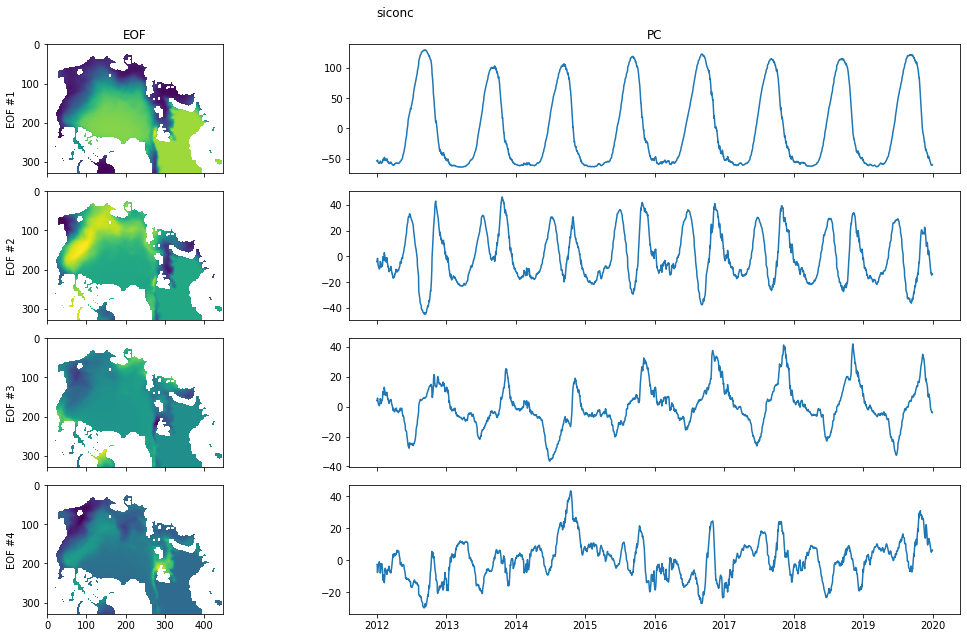

KeyError: 'sisnthick'

In [13]:
# ------------ PLOT ------------

for field in covar_fields:
    filename = f'{rootdir}{fig_dir}{field}_PCA{n_components}_SITass_EOF_PC{suffix}.png'
    visualize_pca.plot_eof2D(chrono_co, EOF2d_co[field], PCs_co[field], field, ofile=filename, showfig=True)

Fig saved as: /nird/projects/nird/NS2993K/Leo/results/xgb_Npred22_7F_rw15d_N8844_H1333_Hn0000_sithick_artc_221003-160817/figures/siconc_PCA_train.png


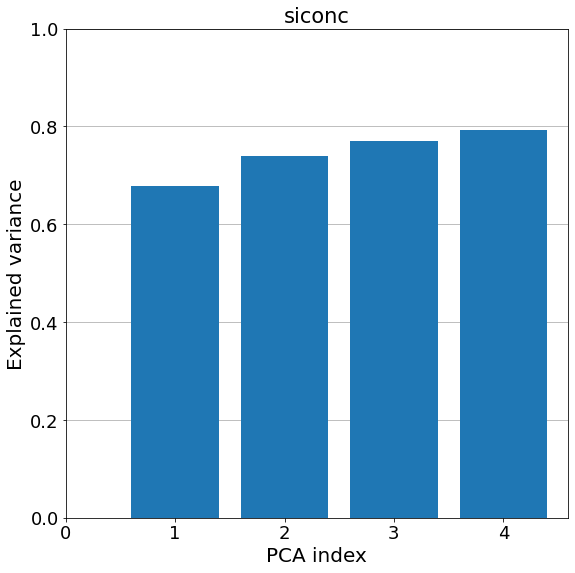

KeyError: 'sisnthick'

In [15]:
for i, field in enumerate(covar_fields):
    filename = f'{rootdir}{fig_dir}{field}_PCA{suffix}.png'
    visualize_pca.plot_pca_variance(n_components, PCA_co[field], field, True, filename)

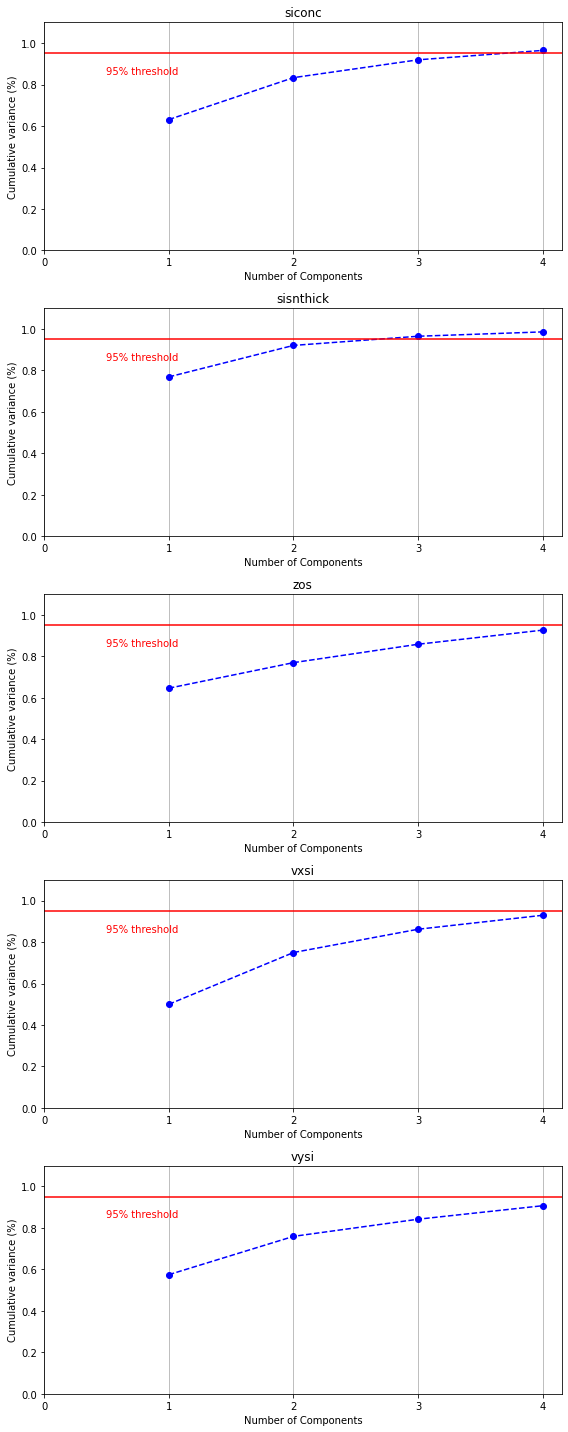

In [18]:
filename = f"{rootdir}{fig_dir}covar_Ncomp_variance.png"
visualize_pca.plot_ncomp_var(PCA_co, covar_fields, True) # , filename)